In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import collections
import copy
import sys
sys.stdout.flush()

from processing_functions import *

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['mathtext.rm'] = 'serif'
rcParams['mathtext.it'] = 'serif:italic'
rcParams['mathtext.bf'] = 'serif:bold'
rcParams['axes.titlepad'] = 12

In [2]:
from concurrent.futures import ProcessPoolExecutor as Pool

### Calculate inverse covariance matrices by combination.

In [3]:
jkcov = (np.load('Run_30_bins_for_all/jk_21p0_x.npz')['jkcov']+np.load('Run_30_bins_for_all/jk_21p0_y.npz')['jkcov']\
             +np.load('Run_30_bins_for_all/jk_21p0_z.npz')['jkcov'])/3.
fidreal = np.load('Run_30_bins_for_all/fidreal_21p0.npz')['func']
fidrandom = np.load('Run_30_bins_for_all/fidrandom_21p0.npz')

covtot = calc_covariance(jkcov,fidreal,fidrandom)
cov_cut = apply_to_dict(cov_clean,cut_by_func_2D(covtot))
nzidx_cut = apply_to_dict(cov_clean,cut_by_func_2D(covtot),return_idx=1)
invcov_cut = apply_to_dict(inv_cov,cov_cut,rcond=1e-4)

p0 = p21p0
oneside = oneside_ranges[4]

In [4]:
keylist = ['w','d','v','c','a','r','wd','wv','wc','wa','wr','dv','dc','da','dr','vc','va','vr','ca','cr','ar',\
        'wdv','wdc','wda','wdr','wvc','wva','wvr','wca','wcr','war','dvc','dva','dvr','dca','dcr','dar',\
         'vca','vcr','var','car','wdvc','wdva','wdvr','wdca','wdcr','wdar','wvca','wvcr','wvar','wcar',\
        'dvca','dvcr','dvar','dcar','vcar','wdvca','wdvcr','wdvar','wdcar','wvcar','dvcar','wdvcar']

### Get smoothing parameters:

#### Use one seed for smoothing test.

In [5]:
pertfunc_eg = np.load('Run_30_bins_for_all/pert_21p0_23431.npz')['func_all']
pertparam_eg = np.load('Run_30_bins_for_all/pert_21p0_23431.npz')['param']
func_cut_eg = apply_to_dict(pert_clean,cut_by_func_1D(pertfunc_eg,axis=1),nzidx_cut)

In [6]:
def get_alphas(combkey):
    return iterated_alpha(func_cut_eg[combkey],invcov_cut[combkey],pertparam_eg,p0,oneside)

In [7]:
alphas_cut = {}

with Pool(55) as pool:
    for i, output_data in enumerate(pool.map(get_alphas, keylist)):
        alphas_cut[keylist[i]] = output_data

In [8]:
alphas_cut_21p0 = copy.deepcopy(alphas_cut)
%store alphas_cut_21p0

Stored 'alphas_cut_21p0' (dict)


#### Or load pre-stored smoothing parameters.

In [5]:
%store -r
alphas_cut = alphas_cut_21p0

### Load all seeds, find posterior covariances.

In [6]:
pertfunc_dict, pertparam_dict = load_pert('-21.0')

In [7]:
func_cut = apply_to_dict(cut_by_func_1D, pertfunc_dict, axis=1)

In [8]:
def locfit_for_seed(seed):
    return apply_to_dict(locfit_comb,apply_to_dict(pert_clean,func_cut[seed],nzidx_cut),alphas_cut,xs=pertparam_dict[seed],x0s=p0)

In [9]:
locfit_dict = {}

with Pool(55) as pool:
    for i, output_data in enumerate(pool.map(locfit_for_seed, seed_21p0)):
        locfit_dict[seed_21p0[i]] = output_data

In [10]:
def bundle_locfit_mean(seeds):
    locfit_bundle_mean = {}
    for k in keylist:
        temp = []
        for seed in seeds:
            temp.append(locfit_dict[seed][k])
        locfit_bundle_mean[k] = mean_of_list(temp)
    return locfit_bundle_mean

In [11]:
n_bundle = 1
bundle_size = 20
postcov_bundles = list()
for i in range(n_bundle):
    locfit_bundle_i = bundle_locfit_mean(seed_21p0[i*bundle_size:(i+1)*bundle_size])
    fisher_bundle_i = apply_to_dict(calc_fisher,locfit_bundle_i,invcov_cut)
    postcov_bundles.append(apply_to_dict(np.linalg.inv,fisher_bundle_i))

In [12]:
postcov_bundles_1_21p0 = copy.deepcopy(postcov_bundles)
%store postcov_bundles_1_21p0
locfit_dict_21p0 = copy.deepcopy(locfit_dict)
%store locfit_dict_21p0

Stored 'postcov_bundles_1_21p0' (list)


In [7]:
def sigma_for_seed(seed):
    locfit_cut = apply_to_dict(locfit_comb,apply_to_dict(pert_clean,func_cut[seed],nzidx_cut),alphas_cut,xs=pertparam_dict[seed],x0s=p0)
    fisher_cut = apply_to_dict(calc_fisher,locfit_cut,invcov_cut)
    return apply_to_dict(np.linalg.inv,fisher_cut)

In [12]:
locfit_wd = locfit_comb(pert_clean(func_cut['23431']['wd'],nzidx_cut['wd']),alphas_cut['wd'],xs=pertparam_dict['23431'],x0s=p0)

In [14]:
locfit_wd_21p0 = locfit_wd
%store locfit_wd_21p0

Stored 'locfit_wd_21p0' (ndarray)


In [15]:
locfit_ca = locfit_comb(pert_clean(func_cut['23431']['ca'],nzidx_cut['ca']),alphas_cut['ca'],xs=pertparam_dict['23431'],x0s=p0)

In [16]:
locfit_ca_21p0 = locfit_ca
%store locfit_ca_21p0

Stored 'locfit_ca_21p0' (ndarray)


In [12]:
postcov_dict = {}

with Pool(55) as pool:
    for i, output_data in enumerate(pool.map(sigma_for_seed, seed_21p0)):
        postcov_dict[seed_21p0[i]] = output_data

In [13]:
sigma2_mean = []
sigma2_std = []
for k in keylist:
    sigma2_mean.append(mean_of_dict(postcov_dict,k).diagonal())
    sigma2_std.append(stddev_of_dict(postcov_dict,k).diagonal())
sigma2_mean = np.array(sigma2_mean)
sigma2_std = np.array(sigma2_std)
sigma_mean = np.sqrt(sigma2_mean)
sigma_stdm = sigma_mean-np.sqrt((sigma2_mean-sigma2_std)*(sigma2_mean-sigma2_std>0))
sigma_stdp = np.sqrt(sigma2_mean+sigma2_std)-sigma_mean

for i,k1 in enumerate(keylist):
    for j,k2 in enumerate(keylist):
        if set(k1).issubset(k2):
            assert all(sigma_mean[i]>=sigma_mean[j])

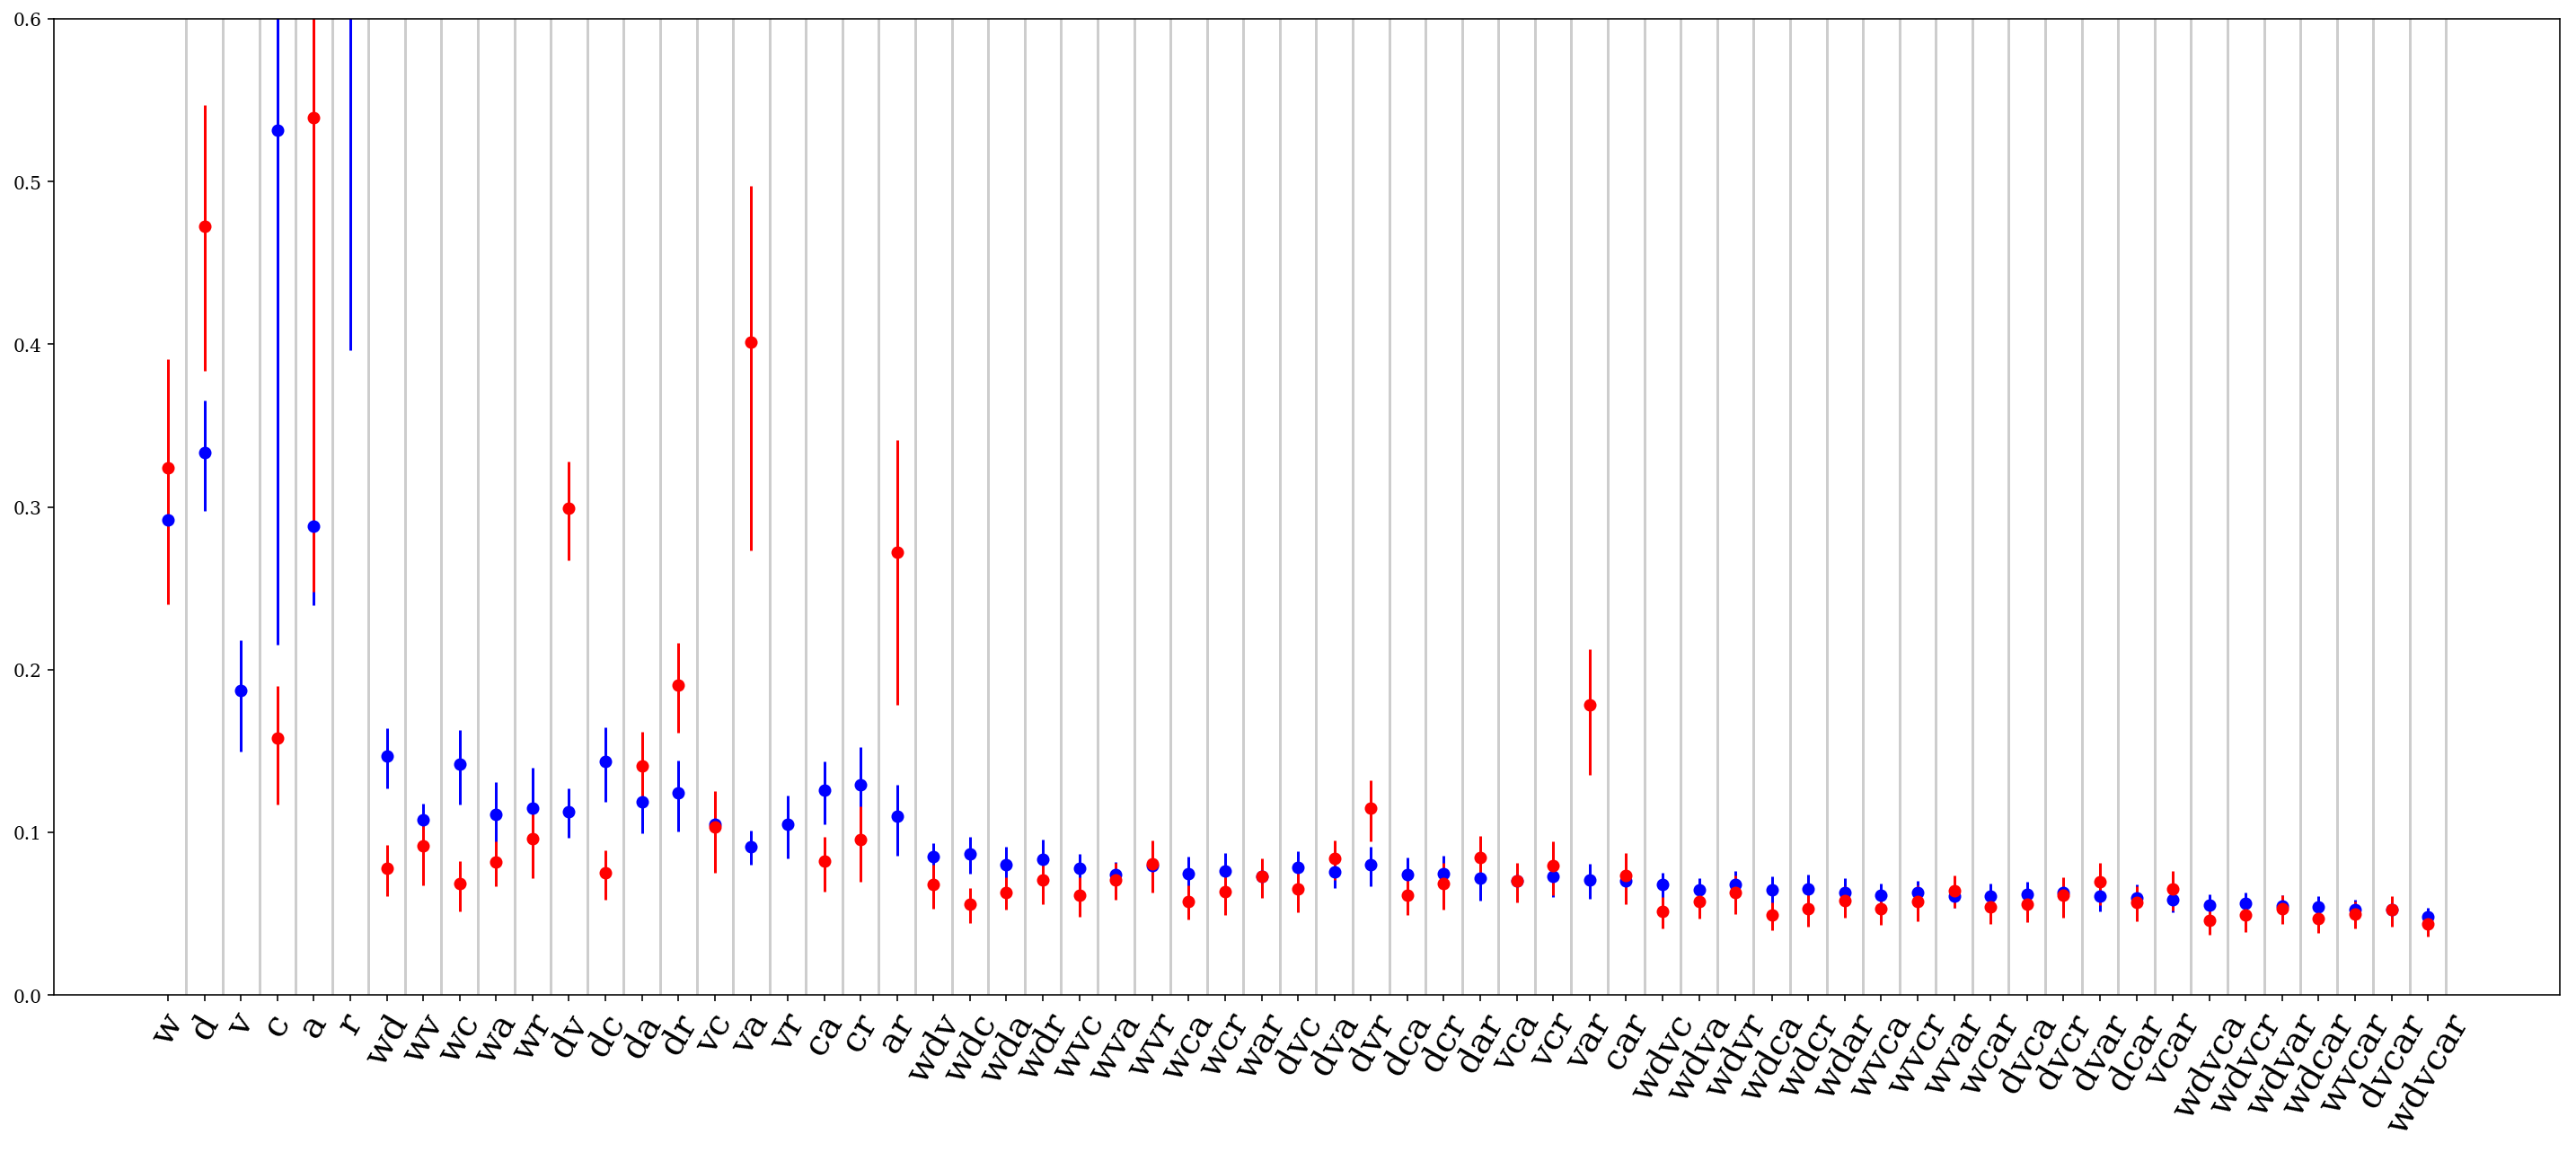

In [14]:
plt.figure(figsize=(25,10))
plt.errorbar(range(len(keylist)),sigma_mean[:,5],yerr=[sigma_stdm[:,5],sigma_stdp[:,5]],ls='none',fmt='o',color='b')
for i in range(len(keylist)):
    plt.axvline(i+0.5,c='k',alpha=0.1)
plt.xticks(range(len(keylist)),keylist,rotation=60,fontsize=20);
#plt.figure(figsize=(25,10))
plt.errorbar(range(len(keylist)),sigma_mean[:,6],yerr=[sigma_stdm[:,6],sigma_stdp[:,6]],ls='none',fmt='o',color='r')
for i in range(len(keylist)):
    plt.axvline(i+0.5,c='k',alpha=0.1)
plt.ylim(0,0.6)
plt.xticks(range(len(keylist)),keylist,rotation=60,fontsize=20);

In [15]:
sigma_mean[0]

array([ 0.11388295,  0.05377648,  0.16340924,  1.23190094,  0.10026855,
        0.29221101,  0.32426701])

### Save results for plotting

In [16]:
sigma_mean_21p0 = np.copy(sigma_mean)
sigma_stdm_21p0 = np.copy(sigma_stdm)
sigma_stdp_21p0 = np.copy(sigma_stdp)

%store sigma_mean_21p0
%store sigma_stdm_21p0
%store sigma_stdp_21p0

Stored 'sigma_mean_21p0' (ndarray)
Stored 'sigma_stdm_21p0' (ndarray)
Stored 'sigma_stdp_21p0' (ndarray)


In [17]:
postcov_dict_21p0 = copy.deepcopy(postcov_dict)
%store postcov_dict_21p0

Stored 'postcov_dict_21p0' (dict)
